# Logistic regression

We are going to do [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) on the famous [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) using a neural network-like implementation, and plot the decision boundary.

# Setup
The topics of this exercise are very famous and very well known, so a lot of educational material is available online. E.g., for logistic regression:

* [Logistic regression @towardsdatascience](https://towardsdatascience.com/understanding-logistic-regression-9b02c2aec102)
* [Logistic regression @Biochemia Medica](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3936971/)
* [Logistic regression @datacamp](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)

Let's just frame the terms of the first part of the problem:
* we are talking about **binary** classification: all samples belong to two classes (represented by values 0 and 1). We want to build a statistical machine able to predict, for a new sample, the class
* for each sample we have a set of numbers, called **features**. The easiest-to-understand case is when these features are actual phyisical measurements, but any set of data will do
* in **standard regression** we weight each feature with a number (positive or negative, big or small). We then multiply each feature times its weight and add everything...
* ...but we cannot do that now, since the resulting number could be very big (positive big or negative big). But our desired result is a class! In other words our machine needs to produce either a zero or a one. Or maybe **all the numbers between zero and one**, so that we have an idea about how certain our prediction is
* in fact, a 0.99 will show more confidence than a 0.8, which will give more confidence than a 0.65, even if all three outputs at the end can be considered as "class 1" (since those numbers are closer to 1 than to 0) 
* to do so we feed what is produced by a regular regression into a **sigmoid function**, which looks like this:

<img src="https:///raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/Logistic-curve.png" width="400">

This function takes in input any number from -infinity to +infinity and returns a value between zero and one. This will be our prediction. Let's start building the solution.

## Loading libraries and setting the random seed

First of all, we load some necessary libraries; then we setup the random seed to ensure reproducibility of results. Since tensorflow uses an internal random generator we need to fix both the general seed (via numpy `seed()`) and tensorflow seed (via `set_seet()`)

In [1]:
#libraries
import numpy as np

In [2]:
## setting seeds
from numpy.random import seed
seed(777)

import tensorflow as tf
tf.random.set_seed(777)

# The Iris dataset

The dataset we are going to use is very famous. It was published by Robert Fisher in 1936 together with the paper [The use of multiple measurements in taxonomic problems](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1469-1809.1936.tb02137.x). Data are public and nowadays this dataset is shipped with many statistical software and packages. We are going to use the copy coming with [sci-kit learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris).

First of all, let's verify the sci-kit version available:

In [3]:
import sklearn.datasets
print(sklearn.__version__)

1.0.2


If we had version 0.23+ we could simply do:

> `iris = sklearn.datasets.load_iris(return_X_y = False, as_frame = True)`

But the above instruction would generate an error with the current installation. The main difference is in the format used to store data: numpy array (version 0.22 and below) or pandas dataframe/series (version 0.23 and above). Since we want to use the pandas data structure the returned data require a little conversion:

In [4]:
import pandas as pd

iris = sklearn.datasets.load_iris()
iris.data = pd.DataFrame(iris.data, columns=iris.feature_names) #converting numpy array -> pandas DataFrame
iris.target = pd.Series(iris.target) #converting numpy array -> pandas Series

The variable `iris` is now a [bunch object](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html#sklearn.utils.Bunch) and contains all the required data.

In [5]:
#uncomment the following instruction to print a detailed description
#of the Iris dataset, here omitted for compactness
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

The dataset describes 150 flower samples, belonging to three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and of the petals, in centimeters. Features are found in the attribute `.data` of the returned bunch object:

In [6]:
print('Shape of the feature table: ' + str(iris.data.shape))

Shape of the feature table: (150, 4)


We can take a look at the actual numbers:

In [7]:
print(iris.data)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


As said above, each of the 150 lines represents a different flower, each belonging to one of the three Iris species. The species will be our target, the class that we are trying to predict. Let's take a look into the dataset:

In [8]:
print('Shape of the target variable: ' + str(iris.target.shape))
print('Names for each class: ' + str(iris.target_names))

#using Counter object to print a tally of the classes
from collections import Counter
print('Numerosity for each class: ' + str(Counter(iris.target)))

Shape of the target variable: (150,)
Names for each class: ['setosa' 'versicolor' 'virginica']
Numerosity for each class: Counter({0: 50, 1: 50, 2: 50})


Classes are represented via a numeric index: 0 for *setosa*, 1 for *versicolor*, 2 for *virginica*. The samples are presented in order, with the first 50 samples being *setosa*, then 50 *versicolor* and the last 50 being *virginica*.

Always when working with a new datasets it is importat to plot the data if possible. We are unfortunately talking about a 5-dimensional dataset (the four features + the target class) which is not easily representable. One solution in these cases is to slice a subset of the whole dataset.

In the following code we'll plot two features at a time, plus the class.

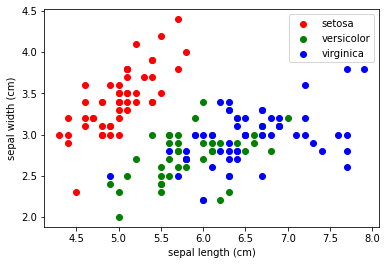

In [9]:
#change these two values to plot different features, remembering the numbering:
# 0 : sepal length (cm)
# 1 : sepal width (cm)
# 2 : petal length (cm)
# 3 : petal width (cm)
feature_x = 0
feature_y = 1

#old reliable pyplot!
import matplotlib.pyplot as plt

#starting a new plot
fig, ax = plt.subplots()

#adding data in three bunches of 50, once per class
ax.scatter(x=iris.data.iloc[0:50,feature_x],    y=iris.data.iloc[0:50,feature_y],    c='red',   label=iris.target_names[0])
ax.scatter(x=iris.data.iloc[50:100,feature_x],  y=iris.data.iloc[50:100,feature_y],  c='green', label=iris.target_names[1])
ax.scatter(x=iris.data.iloc[100:150,feature_x], y=iris.data.iloc[100:150,feature_y], c='blue',  label=iris.target_names[2])

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

The plot shows clearly that setosa is quite separate from the other two classes. Even chosing other features for the plot the general result is similar.

To be totally frank, this dataset is quite simple. In fact even if it's not possible to easily plot everything, using the four features most classifier can reach very close to 100% accuracy when trying to separate Setosa from the other species.

To make things a little more interesting we decide to renounce to half of our features, using only the first two columns. Moreover, we join together Setosa and Versicolor. In other words, we want a classifier able to discriminate virginica (which becomes the new class "1") from the other irises (which all together become the new class "0"):

In [10]:
#simplifly the problem: less classes, less features
features = iris.data.iloc[:, 0:2]
target = iris.target

#updating class labels. To makes things difficult we put together old classes 0 and 1
#in a new class (non virginica) and keep old class 2 (virginica) as new class 1.
#For an easier problems put together versicolor and virginica and keep setosa by itself
j = 100 ## split: 50 for setosa vs versicolor+virginica, 100 for setosa+versicolor vs virginica
target[0:j] = 0 
target[j:150] = 1

Let's take a look at the new dataset:

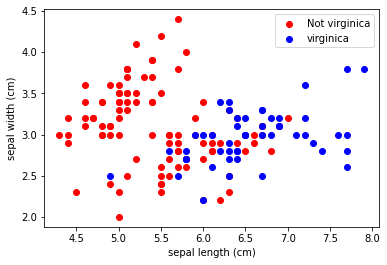

In [11]:
#starting a new plot
fig, ax = plt.subplots()

#adding data in two bunches
ax.scatter(x=features.iloc[0:j,0],   y=features.iloc[0:j,1],   c='red',  label='Not virginica')
ax.scatter(x=features.iloc[j:150,0], y=features.iloc[j:150,1], c='blue', label='virginica')

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

Things are getting interesting! This is now a difficult problem and there is no clear cut solution. Let's proceed.

# Training and validation sets

Each time there is some kind of "learning" involved we need to split our data. A subset will be used for training, and a subset will be used for validation. (there may be room for another subset, the "test set", but we are not talking about it now).

In our current dataset the samples are sorted by class: the first 100 are from "Not virginica" class, and the remaining 50 are from virginica. We want to keep this 2:1 proportion (roughly) the same in both train and validation set.

In [12]:
#selecting the first 100 samples for training would be a bad choice...
print(Counter(iris.target[0:100]))

Counter({0: 100})


To do so we are going to use what is called a [stratified approach](https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/) using a [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) object from Sci-kit learn:

In [13]:
#we want to have the same proportion of classes in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

#the .split() method returns (an iterable over) two lists which can be
#used to index the samples that go into train and validation sets
for train_index, val_index in sss.split(features, target):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target[train_index]
    target_val     = target[val_index]
    
#let's print some shapes to get an idea of the resulting data structure
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

print(type(features_train))
print(type(target_train))

(120, 2)
(30, 2)
(120,)
(30,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


It appears that we are using 20% of our data (30 out of 150) for the validation set and the other 80% for the train set.

In [14]:
print(Counter(target_train))
print(Counter(target_val))

Counter({0: 80, 1: 40})
Counter({0: 20, 1: 10})


# Logistic regression using Keras

While most statistical packets implement some form of logistic regression in this exercise we are interested in using Keras, which is a library aimed to (Deep) Neural Networks.  
Actually logistic regression plays an important role in neural networks and it's typically used in the last (or second to last) layer of a classifier. For more details on how to use keras a good starting point is the [documentation on training and evaluation](https://www.tensorflow.org/guide/keras/train_and_evaluate).

Our neural network will be very easy and very minimal, and will be comprised of only one node (neuron) implementing both regression and sigmoid function. 

<img src="https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/sigmoid_neuron.png">

We are now ready to build the model! 

### Model set-up

In [15]:
activation_function = 'sigmoid'
optimizing_method = 'rmsprop'
loss_function = 'binary_crossentropy'

In [16]:
#we are building a "sequential" model, meaning that the data will 
#flow like INPUT -> ELABORATION -> OUTPUT. In particular, we will
#not have any loops, i.e. our output will never be recycled as
#input for the first layer
from keras.models import Sequential

#a "dense" layer is a layer were all the data coming in are connected
#to all nodes. In our case there is only one node in the layer, and
#it receives all the features
from keras.layers import Dense

# 2-class logistic regression in Keras
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=features_train.shape[1]))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model.compile(optimizer='rmsprop', loss='binary_crossentropy')

Let's take a look inside the model:

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


Keras informs us that there are three trainable parameters (W1, W2, B), and a single node. The output is a single number. Excellent.

We have now prepared everything we need and are ready to train the model on our data. It's an iterative process that cycles many times through what are called `epochs`. We'll start with ten:

In [18]:
history = model.fit(features_train, target_train, epochs=10, validation_data=(features_val, target_val))

Epoch 1/10
4/4 [==============================] - 1s 69ms/step - loss: 0.6551 - val_loss: 0.6609
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6397 - val_loss: 0.6504
Epoch 3/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6295 - val_loss: 0.6419
Epoch 4/10
4/4 [==============================] - 0s 12ms/step - loss: 0.6210 - val_loss: 0.6340
Epoch 5/10
4/4 [==============================] - 0s 11ms/step - loss: 0.6131 - val_loss: 0.6272
Epoch 6/10
4/4 [==============================] - 0s 12ms/step - loss: 0.6065 - val_loss: 0.6214
Epoch 7/10
4/4 [==============================] - 0s 12ms/step - loss: 0.6006 - val_loss: 0.6158
Epoch 8/10
4/4 [==============================] - 0s 11ms/step - loss: 0.5947 - val_loss: 0.6103
Epoch 9/10
4/4 [==============================] - 0s 12ms/step - loss: 0.5889 - val_loss: 0.6047
Epoch 10/10
4/4 [==============================] - 0s 12ms/step - loss: 0.5836 - val_loss: 0.6003


We asked for ten epochs and the network did just that. At each iteration the network is trying really hard to minimize a [value called "loss"](https://keras.io/api/losses/). The specifics are defined by our choice of loss function (we selected `binary_crossentropy`). The basic idea is that the smaller the loss the better the fit.

Note that the network minimizes the loss on the training set and does not use the validation set during the learning process. It can however measure the loss on the validation set to give us an idea on how well it can generalize on new data.

It's handy at this point to define a function that takes in the `history` object returned by `.fit()` and plots it:

In [19]:
#function to take a look at losses evolution
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

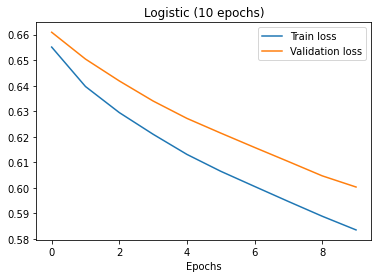

In [20]:
plot_loss_history(history, 'Logistic (10 epochs)')

The good news is that loss just goes down, both in train and validation set. We can keep training - without recompiling, we just add new epochs to our network.

In [21]:
#putting verbose to 0 to avoid filling the screen
history2 = model.fit(features_train, target_train, epochs=490, 
                     validation_data=(features_val, target_val), verbose=0)

Let's see if we improved:

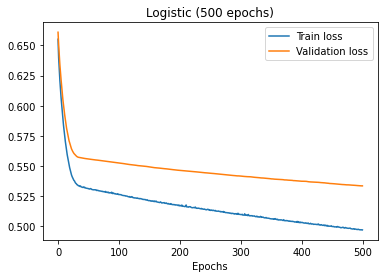

In [22]:
#putting together the whole history
history.history['loss'] += history2.history['loss']
history.history['val_loss'] += history2.history['val_loss']

#and plotting again
plot_loss_history(history, 'Logistic (500 epochs)')

This is very informative: losses keep shrinking, meaning that the network keeps improving. However after a first phase of steep improvement the gain for each epoch slows down considerably.

Moreover, we now see a clear difference between train and validation set. This means that, while the network keeps improving, its performances on new data are expected to be worse than those on the training data.

Now, we could ask: what happens if we keep training for a long time? We have prepared the code for 10000 epochs, but it takes a long time to run, and it's faster if we simply show the saved results (but you can try to run it putting the following flag to `True`):

In [23]:
do_10000_epochs = False

In [24]:
#what happens if we keep going for a (very) long time?
if (do_10000_epochs):
    #train for 10000 epochs, just to show how the model evolves
    history3 = model.fit(features_train, target_train, epochs=9500, 
                         validation_data=(features_val, target_val), verbose=0)

    #putting together the whole history
    history.history['loss'] += history3.history['loss']
    history.history['val_loss'] += history3.history['val_loss']

    #and plotting again
    plot_loss_history(history, 'Logistic (10000 epochs)')

Our pre-recorded results look like this:

![regression_10000_epochs](https://raw.githubusercontent.com/ne1s0n/coding_excercises/master/data/regression_loss10000.png)

It appears that there is constant, slow improvement on training set. Improvement on validation set is slower, and if we had the patience to go for a veeeery long time the orange curve would become completely flat. 

# Decision Boundary

The assignment asks us to plot the [decision boundary](https://en.wikipedia.org/wiki/Decision_boundary), i.e. a representation in the feature space of the criterions the model is using to classify your data. For this task we'll use the [mlxtend module](http://rasbt.github.io/mlxtend/), which unfortunately does not come with the standard installation. Let's add it!

In [25]:
!pip install mlxtend ##execute shell command

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We can now import `mlxtend` package safely.

/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


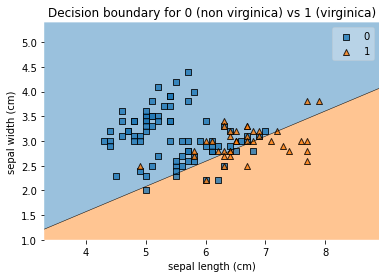

In [26]:
from mlxtend.plotting import plot_decision_regions

#we'll print the training set
plot_decision_regions(X = features_train.to_numpy(), y = target_train.to_numpy(), clf=model)
plt.title('Decision boundary for 0 (non virginica) vs 1 (virginica)')
plt.xlabel(iris.feature_names[feature_x])
plt.ylabel(iris.feature_names[feature_y])
plt.show()

[NOTE: the MatplotlibDeprecationWarning warning depends on [a recent change in matplotlib](https://github.com/rasbt/mlxtend/issues/673), we'll need to wait for mlxtend to be updated in the official pip repo]

The decision boundary is linear, as expected by logistic regression. This means that all samples in the pink area will be classified as 1 (virginica) and all points in the blue area be considered 0 (non virginica).

Note that relatively many virginica samples are in the blue area compared to the numer of non-virginica present in the pink area. Also note that, roughly speaking, the regressor assigned a wider area to non-virginica. This is a direct consequence of having an unbalanced dataset: two-thirds of the samples are non-virginica (blue squares) and one-third are virginica (red triangles). **The resulting regressor is polarised** toward the more numerous class.

# Actual predictions

Any model is only useful when it's used to predict new, unknown data. In fact the whole validation set was put apart and not really used for training for this specific reason. 

Luckily, it's very easy to apply a trained model to new values via the [predict() method](https://keras.io/api/models/model_training_apis/#predict-method).

In [27]:
predictions = model.predict(features_val)
print(predictions)

[[0.22289115]
 [0.42798138]
 [0.28921455]
 [0.5668345 ]
 [0.151564  ]
 [0.18946192]
 [0.42798138]
 [0.30260175]
 [0.49765262]
 [0.6450509 ]
 [0.27618515]
 [0.34743667]
 [0.17050752]
 [0.3626922 ]
 [0.4620466 ]
 [0.4780531 ]
 [0.4815954 ]
 [0.10628644]
 [0.09407464]
 [0.44728714]
 [0.47746292]
 [0.3670774 ]
 [0.34797314]
 [0.44611797]
 [0.10606197]
 [0.3319633 ]
 [0.14232528]
 [0.51312387]
 [0.1999059 ]
 [0.09407464]]


We can now compare the list of prediction (sometimes called Ŷ) with the true classes from our validation set (sometimes called Y).

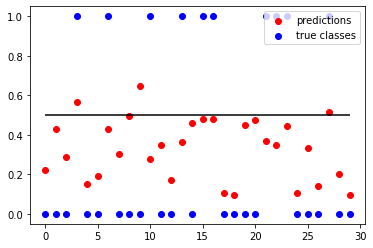

In [28]:
#starting a new plot
fig, ax = plt.subplots()

#adding data in two bunches
ax.scatter(x=range(30), y=predictions, c='red',  label='predictions')
ax.scatter(x=range(30), y=target_val,  c='blue', label='true classes')

#adding a horizontal line at quote 0.5, to represent the decision boundary
ax.hlines(y=0.5, xmin=0, xmax=29, colors='black')

#adding the legend and printing the plot
ax.legend(loc='upper right')
plt.show()

Note that the vast majority of predictions is below the 0.5 line (recall that the closer a prediction is to 0 or to 1 the higher the prediction confidence).

This confirms our suspicions: the regressor prefers to assign new data to the 0 (non virginica) class.

Below, we use the **0.5 threshold** to assign samples to the two classes (0 $\rightarrow$ `non-virginica`; 1 $\rightarrow$ `virginica`.

Then, we compare predicted and true classes in the test set


In [29]:
predicted_class = np.where(predictions > 0.5, "virginica", "non-virginica")
target_class = np.where(target_val == 1, "virginica", "non-virginica")
target_class = target_class.reshape(len(target_class),1)

results = target_class == predicted_class

unique, counts = np.unique(results, return_counts=True)
print("\nN. of mismatches (0s) and matches (1s): ")
print(np.asarray((unique, counts)).T)


N. of mismatches (0s) and matches (1s): 
[[ 0  9]
 [ 1 21]]


From the number of **matches** (`True` comparison $\rightarrow$ 1s) and **mismatches** (`False` comparison $\rightarrow$ 0s) we can calculate the total **error rate**:

In [30]:
if len(counts) > 1:
   n_matches = counts[1]
   n_mismatches = counts[0]
else:
  n_matches = counts[0]
  n_mismatches = 0
  
error_rate = n_mismatches/(n_mismatches+n_matches)
print("Error rate is: {:.2f}".format(round(error_rate,4)))

Error rate is: 0.30


From the error rate we can derive the **overall accuracy**, by simply taking `1 - error rate`:

In [31]:
print("Accuracy is: ", 1 - error_rate)

Accuracy is:  0.7


#### Confusion matrix

Besides the overall error rate, we need to look at the accuracy in the subclasses. This is especially important when data are unbalanced. We can have a more comprehensive assessment of the performance of a classification model by looking at the <a href="https://en.wikipedia.org/wiki/Confusion_matrix">confusion matrix</a>:

In [32]:
predicted_class

array([['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['non-virginica'],
       ['virginica'],
       ['non-virginica'],
       ['non-virginica']], dtype='<U13')

In [33]:
from sklearn.metrics import confusion_matrix

labels = ['non-virginica','virginica']
con_mat_df = confusion_matrix( y_true = target_class, y_pred = predicted_class, labels=labels)
pd.DataFrame(
    con_mat_df, 
    index = ['pred:'+x for x in labels],
    columns = ['true:'+x for x in labels])

,true:non-virginica,true:virginica
pred:non-virginica,19,1
pred:virginica,8,2


# Exercise: do it yourself! (optional)

In the above illustration we used one single keras node with sigmoid activation function to perform logistic regression on a binarised version (two classes) of the `Iris` dataset. Only two features were used.

It is now time for you to try write your own code!

There are several things that can be tried as variation on the above code:

* what is the effect of including the other two features, which we excluded above? Does performance improve? What happens to decision boundary? 
* when implementing the network we used [rmsprop optimizer](https://keras.io/api/optimizers/rmsprop/) and [binary_crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) loss function, but other [optimizers](https://keras.io/api/optimizers/) and [loss functions](https://keras.io/api/losses/) are available and their effect could be explored


In [ ]:
iris = sklearn.datasets.load_iris()
iris.data = pd.DataFrame(iris.data, columns=iris.feature_names) #converting numpy array -> pandas DataFrame
iris.target = pd.Series(iris.target) #converting numpy array -> pandas Series

In [ ]:
features = iris.data
target = iris.target

In [ ]:
features

In [ ]:
j = 100 ## split
target[0:j] = 0 
target[j:150] = 1

In [ ]:
np.unique(target, return_counts=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
input_shape = features.shape[1]

In [ ]:
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=input_shape))

In [ ]:
print(model.summary())

In [ ]:
model.compile(optimizer='rmsprop' ,  loss='binary_crossentropy')

In [ ]:
history = model.fit(features, target, epochs=100, verbose=0)

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
predictions = model.predict(features)
predictions

In [ ]:
predicted_class = np.where(predictions > 0.5, "virginica", "non-virginica")
target_class = np.where(target == 1, "virginica", "non-virginica")
target_class = target_class.reshape(len(target_class),1)

results = target_class == predicted_class
results

In [ ]:
from sklearn.metrics import confusion_matrix

labels = ['non-virginica','virginica']
con_mat_df = confusion_matrix( y_true = target_class, y_pred = predicted_class, labels=labels)
pd.DataFrame(
    con_mat_df, 
    index = ['pred:'+x for x in labels],
    columns = ['true:'+x for x in labels])

#### On your own (super optional!)

* to improve our understanding of logistic regression we could implement it from scratch, without using keras, following the [steps detailed here](https://towardsdatascience.com/a-logistic-regression-from-scratch-3824468b1f88) (but only if we are very brave)